# SIMULATIONS
## Import and helper functions

In [1]:
import workload_simulation
import forgetting_curve as fc
import matplotlib
import importlib
import numpy
from operator import itemgetter

In [2]:
importlib.reload(workload_simulation)
import workload_simulation as ws

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
SimulationResult = ws.SimulationResult
%matplotlib inline

In [4]:
def adapt_simulations_to_newcardcost(sims, cost_new_card):
    new_sims = []
    for sim in sims:
        pbt = sim.pbt
        factor = sim.factor
        workload = sim.w_load + cost_new_card
        efficiency = sim.r_rate / workload
        new_sims.append(SimulationResult(pbt, sim.r_rate, workload, efficiency, factor))
    return new_sims

In [5]:
def get_simdata(fp, cardcost=0):
    sims = ws.get_simdata(fp)
    return adapt_simulations_to_newcardcost(sims, cardcost)

In [6]:
def get_closest_factor(new_factor, total_output):
    for r in total_output:
        if r.factor >= new_factor:
            return r

In [7]:
def printsim(sim, name, forcomparison=False):
    name = name.center(10)
    print(f"{name} | {sim.factor:0.2f} | {sim.pbt:0.2f} | {sim.r_rate:0.2f} | {sim.w_load:0.2f} | {sim.efficiency:0.2f}")

def print_header():
    print(" "*10+" |factor| pbt  | ret  | load  | effi")

def analysis(total_output, new_factor=None):
    factors = [output.factor for output in total_output]
    r_rates = [output.r_rate for output in total_output]
    w_loads = [output.w_load for output in total_output]
    effs = [output.efficiency for output in total_output]
    

    
    plt.scatter(factors, r_rates,  color='blue')
    #t = np.polyfit(factors,r_rates,1)
    #new_rates = [t[0]*f + t[1] for f in factors]
    #plt.plot(factors,new_rates, color="red")
    plt.xlabel("Factors")
    plt.ylabel("Retention rate")
    if new_factor is not None:
        plt.plot([new_factor, new_factor], [min(r_rates), max(r_rates)], color="green", lw=1)
    plt.plot([2.5, 2.5], [min(r_rates), max(r_rates)], 'k-', lw=1)
    plt.show()
    plt.scatter(factors, w_loads,  color='red')
    plt.xlabel("Factors")
    plt.ylabel("workload")
    if new_factor is not None:
        plt.plot([new_factor, new_factor], [min(w_loads), max(w_loads)], color="green", lw=1)   
    plt.plot([2.5, 2.5], [min(w_loads), max(w_loads)], 'k-', lw=1)
    plt.show()
    plt.scatter(factors, effs,  color='green')
    if new_factor is not None:
        plt.plot([new_factor, new_factor], [min(effs), max(effs)], color="green", lw=1)  
    plt.plot([2.5, 2.5], [min(effs), max(effs)], 'k-', lw=1)
    t = np.polyfit(factors,effs, 3)
    #new_effs = [t[0]*f*f*f + t[1]*f*f + t[2]*f + t[3] for f in factors]
    #plt.plot(factors,new_effs, color="blue")
    plt.xlabel("Factors")
    plt.ylabel("efficiency")
    plt.show()
    
    
    # PRINT INSIDE TABLE

    best_productivity = max(total_output, key=lambda x:x.efficiency)
    least_work = min(total_output, key=lambda x:x.w_load)
    print_header()
    if new_factor is not None:
        sm2 = get_SM2_Point(total_output)
        printsim(sm2, name="SM2")
        print("---")
        closest_new_factor = get_closest_factor(new_factor, total_output)
        print("User Defined Factor")
        printsim(closest_new_factor, "Absolute")
        printsim(compare(closest_new_factor, sm2), "VS SM2")
        print("---")
    print("Max Eff")
    printsim(best_productivity, "Absolute")
    printsim(compare(best_productivity, sm2), "VS SM2")
    print("---")
    print("Least Work")
    printsim(least_work, "Absolute")
    printsim(compare(least_work, sm2), "VS SM2")
#analysis(total_output)

In [8]:
def get_SM2_Point(results):
    for r in results:
        if r.factor == 2.5:
            return r

def compare(source, target):
    return SimulationResult(source.pbt - target.pbt, 
                            source.r_rate - target.r_rate, 
                            (source.w_load)/(target.w_load), 
                            source.efficiency/target.efficiency, 
                            source.factor/target.factor)

def compare_best_to_sm2(results):
    o = get_best_prod(results)
    s = get_SM2_Point(results)
    return compare (o, s)

def get_best_prod(results):
    return max(results, key=lambda x: x.efficiency)

In [9]:
def plot_comparison(difs, c_wlds, c_rets, c_pbts):
    fig, ax1 = plt.subplots()
    ax1.scatter(difs, c_wlds, color="red")
    ax1.set_xlabel('Initial Success Rate')
    ax1.set_ylabel('Workload Fraction', color='red')
    ax1.tick_params('y', colors='red')

    ax2 = ax1.twinx()
    ax2.scatter(difs, c_rets, color="blue")
    ax2.set_ylabel('Retention Rate Loss', color='blue')
    ax2.tick_params('y', colors='blue')

    fig.tight_layout()
    plt.show()
    
    # copy-pasta
    fig, ax1 = plt.subplots()
    ax1.scatter(difs, c_wlds, color="red")
    ax1.set_xlabel('Initial Success Rate')
    ax1.set_ylabel('Workload Fraction', color='red')
    ax1.tick_params('y', colors='red')

    ax2 = ax1.twinx()
    ax2.scatter(difs, c_pbts, color="blue")
    ax2.set_ylabel('Success Rate Loss', color='blue')
    ax2.tick_params('y', colors='blue')

    fig.tight_layout()
    plt.show()

In [10]:
def display_overall(results, sm2s, diffs, display_SM2=True):
    #results are post-optimized selection for a range of factor
    factors = [output.factor for output in results]
    r_rates = [output.r_rate for output in results]
    w_loads = [output.w_load for output in results]
    effs = [output.efficiency for output in results]
    pbt = [output.pbt for output in results]
    c_wlds=[]
    c_rets=[]
    c_effs = []
    c_pbts = []
    for sim, sm2 in zip(results, sm2s):
        comparesim = compare (sim, sm2)
        c_wlds.append(comparesim.w_load)
        c_rets.append(comparesim.r_rate)
        c_effs.append(comparesim.efficiency)
        c_pbts.append(comparesim.pbt)
    
    plt.scatter(pbt, factors, color="blue")
    #t = np.polyfit(np.asarray(pbt, dtype=float),np.asarray(factors, dtype=float),2)
    #new_factors = [t[0]*p*p + t[1]*p + t[2] for p in pbt]
    #plt.plot(pbt,new_factors, color="red")
    if display_SM2:
        plt.plot([min(pbt), max(pbt)], [2.5, 2.5], color="black", lw=1)
    plt.ylabel("Optimal Factors")
    plt.xlabel('Initial Success Rate')
    plt.show()
    
    plt.scatter(diffs, effs, color="green")
    plt.ylabel("Efficiency Gain")
    plt.xlabel('Initial Success Rate')
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.scatter(diffs, w_loads, color="red")
    ax1.set_xlabel('Initial Success Rate')
    ax1.set_ylabel('Workload After Opti', color='red')
    ax1.tick_params('y', colors='red')

    ax2 = ax1.twinx()
    ax2.scatter(diffs, r_rates, color="blue")
    ax2.set_ylabel('Retention Rate After Opti', color='blue')
    ax2.tick_params('y', colors='blue')

    fig.tight_layout()
    plt.show()
    plot_comparison(diffs, c_wlds, c_rets, c_pbts)

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

In [12]:
length_to_path = {"1year": "simunight", "10years": "simunight10years", "30years": "simunight30years"}
def analyse(success_rate, cost_card, new_factor, length_simulation):
    path = length_to_path[length_simulation]
    try:
        fpath = f"./{path}/{success_rate}.pkl"
        sims = get_simdata(fpath, cost_card)
    except:
        fpath = f"./{path}/{success_rate}.0.pkl"
        sims = get_simdata(fpath, cost_card)
        #TODO : code get_sim_data_from_settings
    print("IM :"+ str(new_factor/2.5))
    return analysis(sims, new_factor)

In [13]:
def range_analysis(cost_card, length_simulation):
    path = length_to_path[length_simulation]
    bests = []
    sm2s= []
    diffs = []
    for file in os.listdir(f"./{path}/"):
        sims = get_simdata(f"./{path}/{file}", cost_card)
        diffs.append(float(file.replace(".pkl","")))
        bests.append(max(sims, key=lambda x:x.efficiency))
        sm2s.append(get_SM2_Point(sims))
    display_overall(bests, sm2s, diffs)
        
    
    #display_overall(results)

## Analyse results of past simulations
### Range analysis

For a broad range of initial success rate, find the factor that maximises efficiency and display the consequences on workload, retention and efficiency. 

The cost of creating new card (how many reviews could have been done instead) and the average length of the simulations are passed as extra hyperparameters.

Black line represents SM2 point (with factor == 2.5)

In [14]:
interact(range_analysis,
         cost_card=widgets.IntSlider(min=0,max=15,step=1,value=5),
         length_simulation = widgets.Dropdown(options=["1year", "10years", "30years"],value='1year',description='length_simulation:')
        );

interactive(children=(IntSlider(value=5, description='cost_card', max=15), Dropdown(description='length_simula…

## Analyse result of simulation with specific succes rate

In [15]:
interact(analyse, success_rate=widgets.IntSlider(min=70,max=97,step=1,value=90), 
         cost_card=widgets.IntSlider(min=0,max=15,step=1,value=5),
         new_factor=widgets.FloatSlider(min=2,max=20,step=0.1,value=4),
         length_simulation = widgets.Dropdown(options=["1year", "10years", "30years"],value='1year',description='length_simulation:')
        );

interactive(children=(IntSlider(value=90, description='success_rate', max=97, min=70), IntSlider(value=5, desc…

## TRASH

Retention rate point loss is distributed between -3pt and -6pts whereas workload diminish fast with Initial Success rate.

Two practical implications :
1. Whatever your initial success rate, if you use the suggested IM, the retention loss is not large.
2. If you have a large Initial Success Rate, you have more interests to use optimized IM's.

## Partial reset mode (failed cards are partially reset), need rework))

## diff 90%

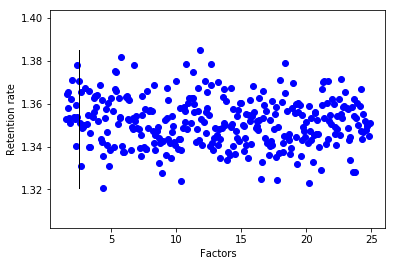

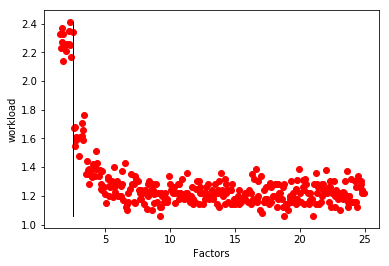

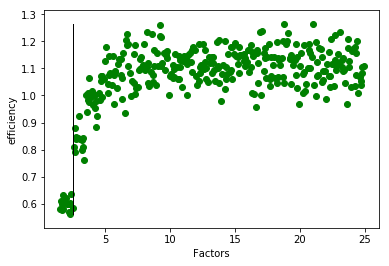

           |factor| pbt  | ret  | load  | effi
Max Eff
 Absolute  | 21.00 | 0.41 | 1.34 | 1.06 | 1.26


UnboundLocalError: local variable 'sm2' referenced before assignment

In [16]:
list_of_factors = [i / 120 for i in range(3 * 60, 10 * 300) if (i % 30 == 0) or (i % 40 == 0) or (i % 12 == 0)]
focus_output = []
focus_output_too_high = []
focus_output_too_low = []
dif = 0.90
total_output = []
for factor in list_of_factors:
    pbt = fc.get_pb_success_from_interval_modifier(factor / 2.5, dif)
    l = ws.sim(pbt, nsims=100, onfail="stable", ndays=1,
            difficulty=dif, factor=factor)
    quotient = l[0] / l[1]
    row = ws.SimulationResult(pbt, l[0], l[1], quotient, factor)
    total_output.append(row)
analysis(total_output)
compare_best_to_sm2(total_output)

##  70% success rate

In [ ]:
list_of_factors = [i / 120 for i in range(3 * 60, 10 * 300) if (i % 30 == 0) or (i % 40 == 0) or (i % 12 == 0)]
focus_output = []
focus_output_too_high = []
focus_output_too_low = []
dif = 0.70
total_output = []
for factor in list_of_factors:
    pbt = fc.get_pb_success_from_interval_modifier(factor / 2.5, dif)
    l = ws.sim(pbt, nsims=100, onfail="stable", ndays=1,
            difficulty=dif, factor=factor)
    quotient = l[0] / l[1]
    row = ws.SimulationResult(pbt, l[0], l[1], quotient, factor)
    total_output.append(row)
analysis(total_output)
compare_best_to_sm2(total_output)

##  95% success rate

In [ ]:
list_of_factors = [i / 120 for i in range(3 * 60, 10 * 300) if (i % 30 == 0) or (i % 40 == 0) or (i % 12 == 0)]
focus_output = []
focus_output_too_high = []
focus_output_too_low = []
dif = 0.95
total_output = []
for factor in list_of_factors:
    pbt = fc.get_pb_success_from_interval_modifier(factor / 2.5, dif)
    l = ws.sim(pbt, nsims=100, onfail="stable", ndays=1,
            difficulty=dif, factor=factor)
    quotient = l[0] / l[1]
    row = ws.SimulationResult(pbt, l[0], l[1], quotient, factor)
    total_output.append(row)
analysis(total_output)
compare_best_to_sm2(total_output)